Micrograd

**Backpropagation**
Computes the derivative of g with respect to a or b using the chain rule, backwards through the network.

This tells you how the output of the network responds when you change x a tiny bit. ("How sensitive the network is, and in which direction basically" — 3b1b's explanation was just a little confusing.)

Backpropagation actually doesn't care about what kind of function it takes in. All it's doing is computing derivatives. That function might be a neural network, or it might be some other kind of math stuff.


Neural networks are just mathematical expressions. They take the input data and the weights of the network as inputs, and output their predictions.

Micrograd breaks everything down into individual scalars — this is for pedagogical reasons. If we go to a prod system, we start working with tensors — but the math doesn't change, it's purely for efficiency.

(Tensors are just arrays of scalars that we package up to take advantage of parallel computing within a computer)


> Micrograd is what you need to train neural networks and everything else is just efficiency.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5 #3*x^2

In [3]:
f(3.0)

20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


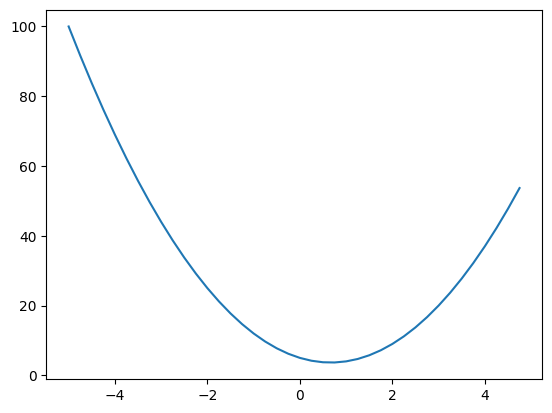

In [4]:
xs = np.arange(-5, 5, 0.25) # generates an array between -5 and 5 by intervals
print(xs)
ys = f(xs)
print(ys)
plt.plot(xs, ys)

Going back to the limit definition of the derivative, where the limit of $f(x-h) - f(x)$ over $h$, we'll look at this from the perspective of a small but not infinitesimal $h$.

In [5]:
h = 0.0001 # eventually we get a wrong answer as h gets very small because we're doing floating-point math.
x = 3.0
(f(x+h) - f(x))/h # an approximation of the slope!! (also colab just prints the statements)

14.000300000063248

Ok, now we can get more complex.

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.001

# inputs: the point (2.0, -3.0, 10.0) where we're going to evaluate the derivative of d
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)



d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


Ok, so we know what the derivative is: it's looking at how the output of the function changes when we look at this tiny little change in one specific output.

We're computing partial derivatives here, though, because we're treating everything here like a constant.

Now we need to move to neural networks -- pretty big expressions.

> "we need data structures that maintain these expressions"

huh?

Also, a quick little thing for how python Classes work:
- `__init__` is a special function that's called when you initialize the thing, and might take parameters (e.g. `john = Person("John", 42)` and

```
class Person:
    __init__(self, name, age):
        self.name = name
        self.age = age

```


Both of the `__leading_and_trailing_underscores__` functions are "magic" method, they just have this special naming style to make them special.

- The `__repr__` function I believe defines a way to generate a string representation of the object.

- the `__add__` function is a  that tells python how to deal with the addition operator. (`+` is defined for strings and floats and ints; we're defining a new data type using `Class` so we need to tell it how to add.)
  - when we use `a + b`, python is actually internally calling `a.__add__(b)`

What we're doing with the "children" thing is creating a graph contained within each value: when `c = a + b`, c also has the property `_children` which contains the values used to create it, `a` and `b`. We also know the operation used to create this value, `_op`, e.g. `c._op` results in `

We can figure out those children using `c._prev` and `c._op`

Karpathy uses the single underscore to [weakly indicate "internal use only"](https://peps.python.org/pep-0008/#descriptive-naming-styles)

`label` is for use when visualizing the values; rather than just knowing them by their value and their children, the label tells you that it represents value `a` or value `b` or whatever.

In [46]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children is a tuple
        self.data = data
        self._prev = set(_children) # uses set for efficiency
        self._op = _op
        self.label = label
        self.grad = 0.0 # by default we assume that the gradient is zero, that it is not changing

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    """ 
    
    # Added down below, but placed here in case I want to export this class somewhere
    
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math.exp(x) = e^x
        out = Value(t, (self, ), 'tanh') # (self, ) is a 1-object tuple
        return out
    """


a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L' # L is the output of the graph

In [11]:
# NO copy-pasting!
!pip install graphviz
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
          edges.add((child, v))
          build(child)
  build(root)
  return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
  nodes, edges = trace(root)
  dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

  for n in nodes:
    dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
        dot.node(name=str(id(n)) + n._op, label=n._op)
        dot.edge(str(id(n)) + n._op, str(id(n)))

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return(dot)


# IT WAS A WHITESPACE ERROR LMAOOOOOOOO
# OK THIS MIGHT PREVENT ME FROM MAKING SIMILAR ERRORS LATER THOUGH



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 661.6 kB/s eta 0:00:000:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


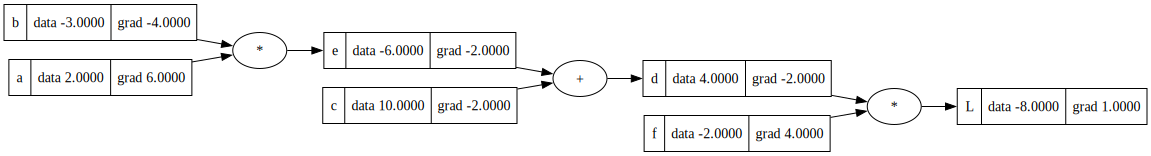

In [25]:
draw_dot(L)

Backprop is gonna go back, and compute the derivative of each node with respect to L. (L stands for loss. these represent the weights in a neural net lol)

### dl/dd
$L(d)= d * f$

$\frac{\partial L}{\partial d} = f$

"**Gradient check**" is when we actually derive the gradient

**Numerical gradient** is when you derive it using small step size

Using limit definition of the derivative:

$\lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$

L(d) = df

$\lim_{h \to 0} \frac{L(d+h)-L(d)}{h}$

$\lim_{h \to 0} \frac{(d+h)*f-d*f}{h}$

$\lim_{h \to 0} \frac{df + hf - df}{h}$

$\lim_{h \to 0} \frac{hf}{h}$

So at the limit, it equals f.

### dl/dc and the chain rule

"The crux of backpropagation!"

Now, for $\frac{\partial L}{\partial c}$:

If we know $\frac{\partial L}{\partial d}$ and $\frac{\partial d}{\partial c}$, we can just use them.

d = c + e, so $\frac{\partial d}{\partial c} = 1$

(by symmetry, dL/de = 1)


Karpathy calls this a "local derivative" -- looking at the local influence of one node, via its influence on other nodes which input the output.

If a variable $z$ depends on the variable $y$, which itself depends on the variable $x$ (that is, $y$ and $z$ are dependent variables), then $z$ depends on $x$ as well, via the intermediate variable $y$. In this case, the chain rule is expressed as $\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$. 

In other words, we're just multiplying the derivatives together. (I think the analytical version of this in calc BC kind of distracted from the point.)

> As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

So, since we know $\frac{dL}{dd}$ and $\frac{dd}{dc}$, we just need to multiply them to get $\frac{dL}{dc}$ bt the chain rule. 

$\frac{dL}{dd} = -2$  and $\frac{dd}{dc} = 1$ so $\frac{dL}{dc} = -2$

**We can think of a plus node as in a sense "routing" derivatives back through the network -- distributing by chain rule the derivatives of the objects further down the line in the network.**

## dL/da by chain rule

$\frac{dl}{de} = -2.0$ and $\frac{dl}{da} = \frac{dl}{de} \cdot \frac{de}{da}$

$e = a \cdot b$

$\frac{de}{da} = 1 \cdot b$

$b = -3$ so $\frac{de}{da} = -3$ and $\frac{dl}{da} = 2 \cdot -3$

## So what just happened? 

Basically, backpropagation is going backwards, approximating the *partial derivative*, and then multiplying together the partial derivatives or something along those lines.

Wait, are these partial derivatives or just regular *derivatives with respect to some thing?* Let's think about this for a moment. We're looking at e = f(a,b) = ab; we say de/da = b -- this is not applying the chain rule, otherwise we'd need to say $\frac{de}{da} = b + a \frac{db}{da}$ by the product rule. We're treating b as a constant, so we're taking partial derivatives. 

This is in line with the idea that gradient descent calculates the gradient -- the vector containing the partial derivatives of the equation -- then adjusts in that direction (I think!? or do you do it progressively? we'll see.)

Wait, wikipedia for backpropagation: 

> The derivative of the loss in terms of the inputs is given by the chain rule; note that each term is a total derivative, evaluated at the value of the network (at each node) on the input.

... these aren't partial derivatives?? I'm confused by this. Wondering what kind of error I'm making. Maybe I should just keep going and then it'll clear up? Let's try that.


In [24]:
L.grad = 1.0

f.grad = 4.0
d.grad = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = 6
b.grad = -4

In [27]:
def lol():  # a little staging area to make all this into local variables
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L' # L is the output of the graph
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    b.data += h

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L' # L is the output of the graph
    L2 = L.data
    
    # remember, this isn't even using a library or anything 
    # -- we're just looking at the approximation of the 
    # derivative by looking at the difference in the output 
    # when we slightly increment c, and then adjusting the 
    # result based on how much we incremented it.

    print((L2-L1)/h) 
    
    


lol()

-4.000000000008441


Ok, now we can go for an optimization step. We have control over the inputs, so if we want L to go up, we can adjust the values of the inputs in the direction of the gradient.

In [32]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# we adjusted the data, now we need to re-run the forward pass

e = a*b
d = e + c
L = d * f

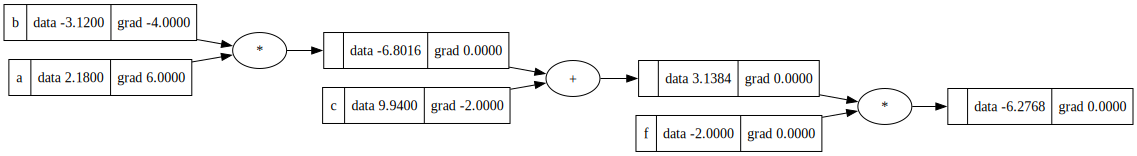

In [33]:
draw_dot(L)

## backpropagation example 2

We're now going to build a neural network. here's a diagram from stanford cs231 that shows the structure: 

take in inputs * weights, then sum them, add a bias, and put them into an activation function.

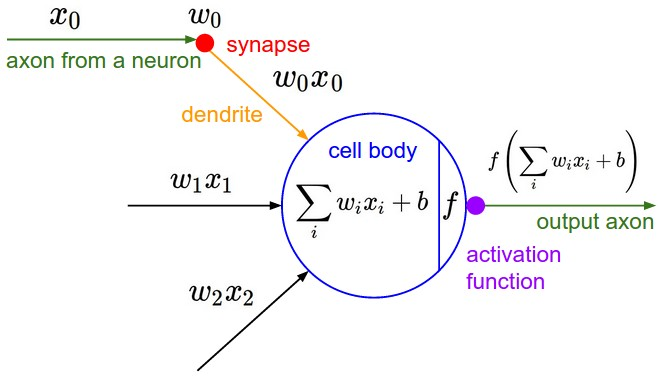

the activation/squashing function we're going to be using here (which in the diagram above would be $f$) is `tanh`, visualized below. (note: isn't tanh a hyperbolic tangent function? isn't that some cool hyperbolic geometry thing or w/e? <span style="background:yellow">*something to look into later*</span>


also, remember the dot product? yeah, that's what that $\sum_{i} w_{i}x_{i}$ is lol
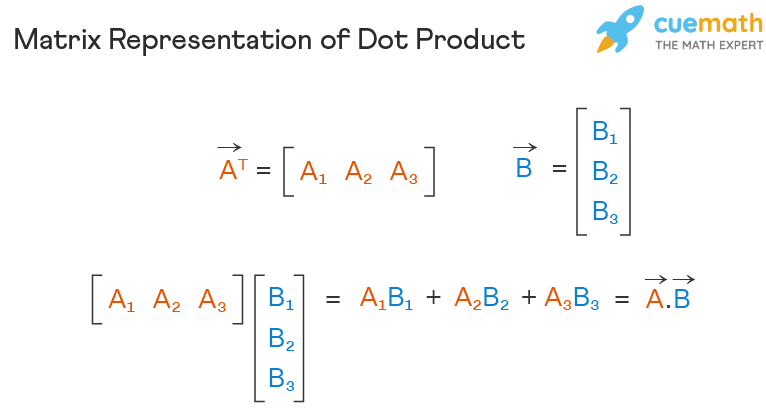

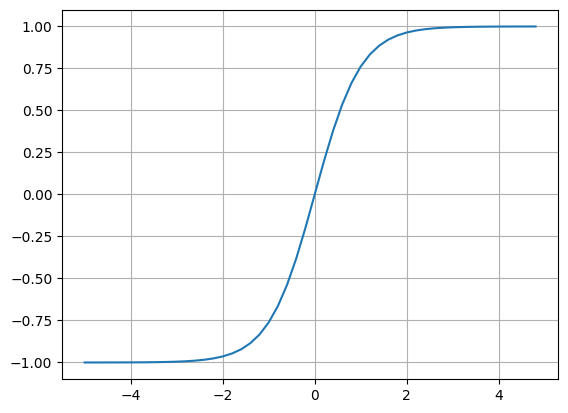

In [35]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

## hyperbolic functions and tanh

so... hyperbolic geometry happens when you replace euclid's parallel postulate with something else.

theres some fucked up shit here. something along the lines of tanh is when you have a tangent function but it's on the hyperbolic plane??? something?


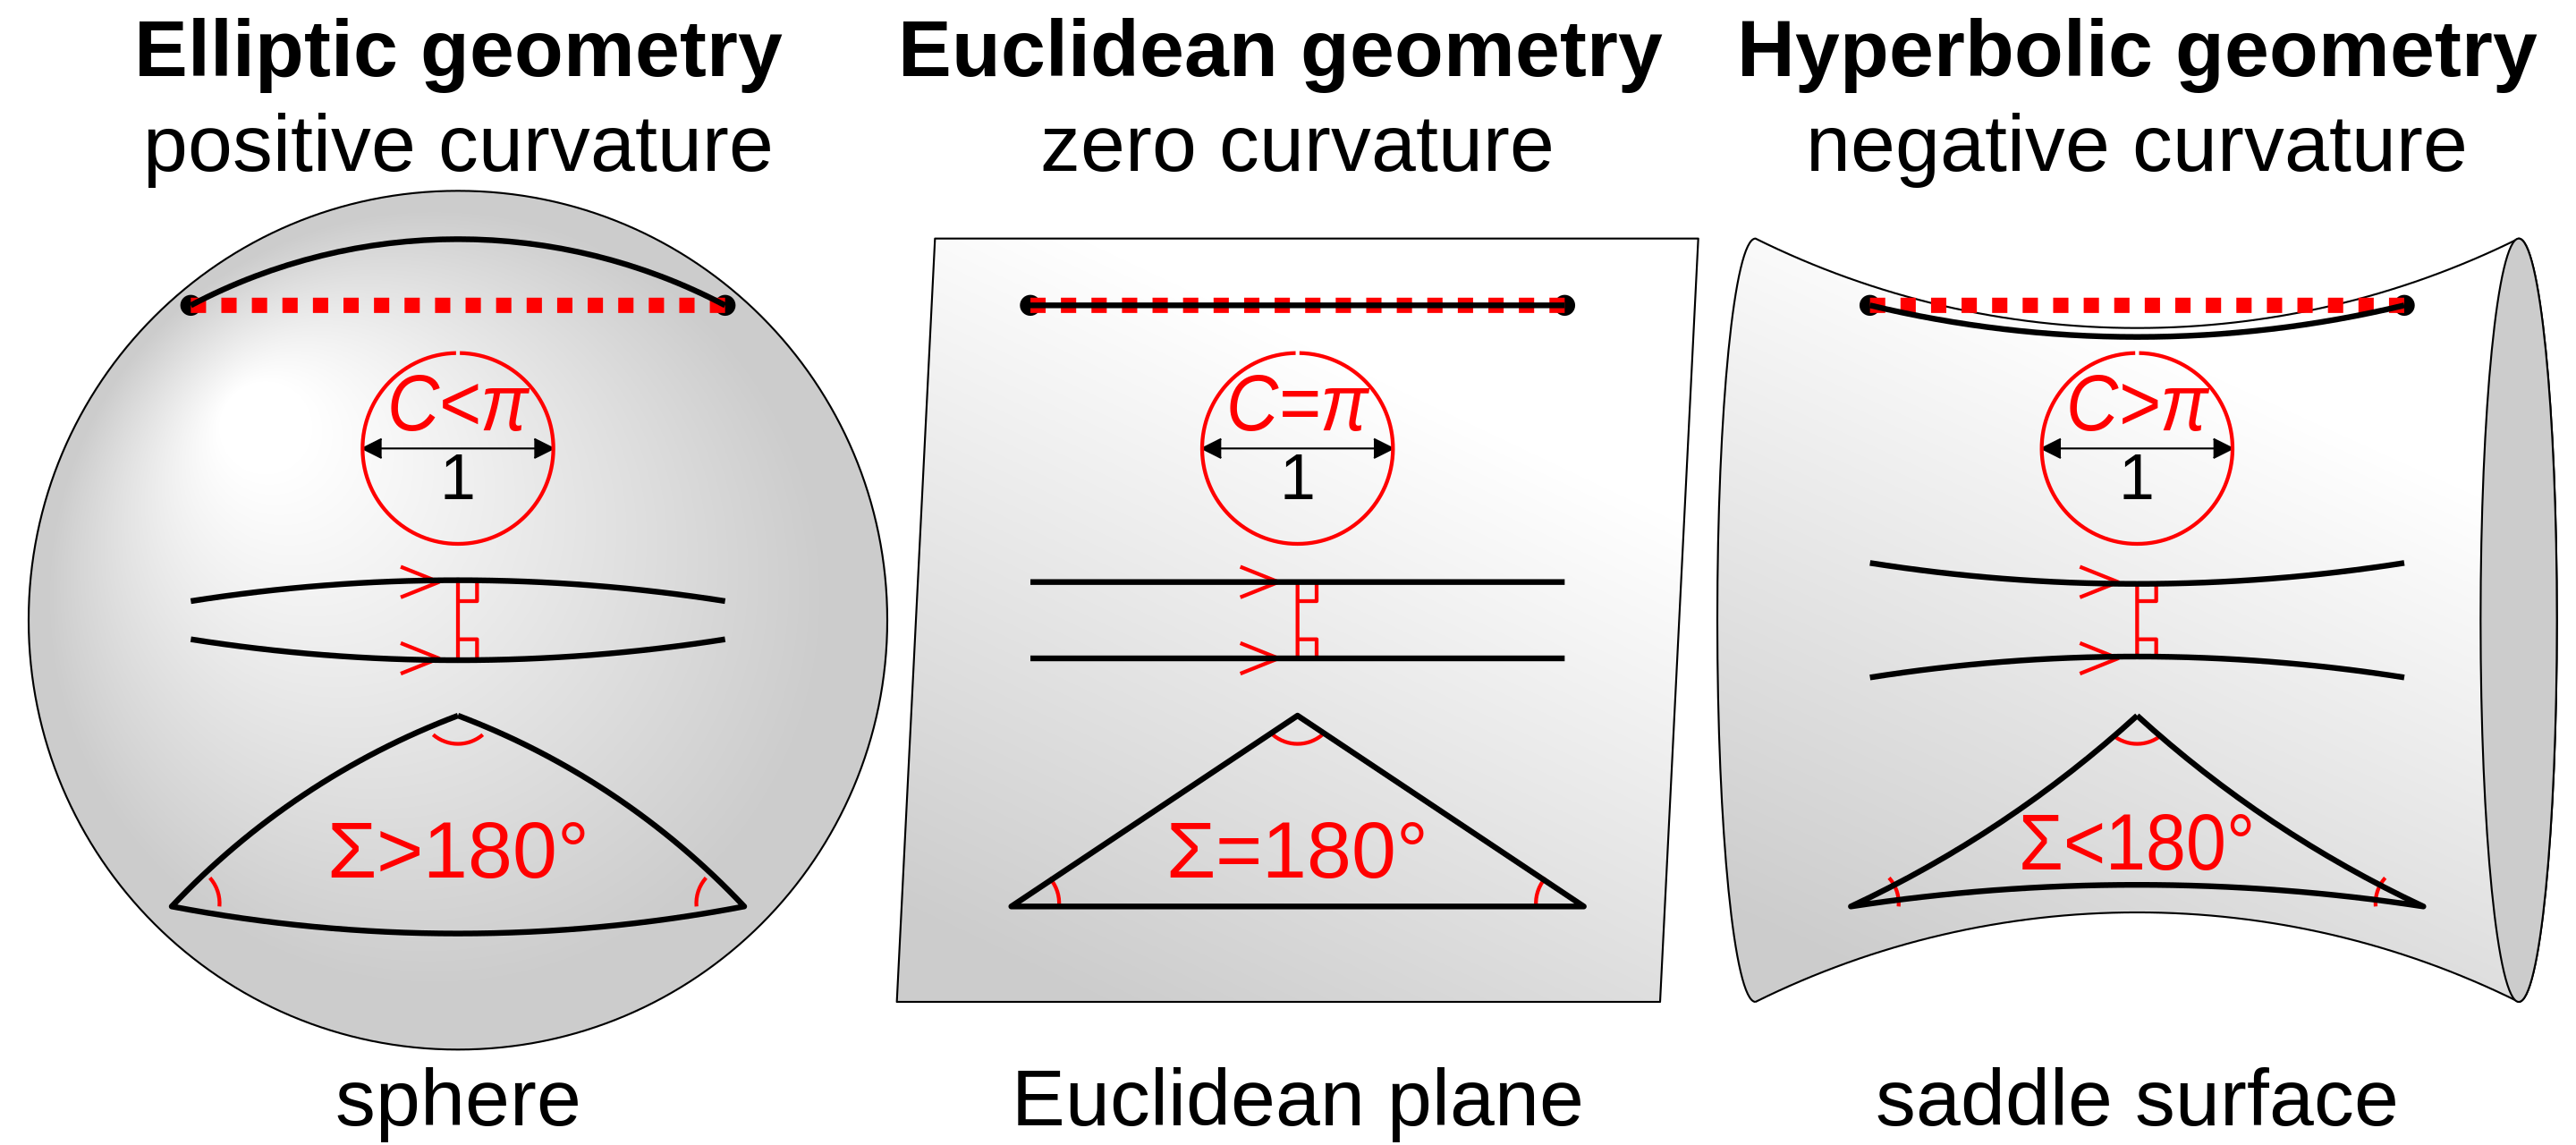

anyway, you use tanh to calculate stuff with functions in hyperbolic geometry. this is <span style="background:yellow">*something to look into later*</span> looks like there are some cool and deep things to explore. anyway.

**definition of tanh:** $\tanh (x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$

it's kind of insane that tanh is defined like this. unhinged. it's not a taylor series or anything, it's just a bunch of $e^{x}$-es.

also i'm going to pronounce `sinh` like "sihnsh" and `tanh` as "tansh", since it's in line with `cosh` ("kosh")

anyway, now we can go reimplement `tanh` as a method on our `Value` class. we can just define functions on arbitrary levels of abstraction as long as we know how to differentiate them (??) , so here we go.

In [44]:
# defined and added to list of methods down here. this is a thing you can do, yes.

def tanh(self): 
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math.exp(x) = e^x
    out = Value(t, (self, ), 'tanh') # (self, ) is a 1-object tuple
    return out
    
Value.tanh = tanh #adds it to list of methods in class Value

In [89]:
# a 2-input neural network

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2 and bias b
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373587, label='b')

#multiply the weights and sum
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# add the bias to get n, which is the 'dot product', our input to the activation function
# (though we haven't added the activation function yet)
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

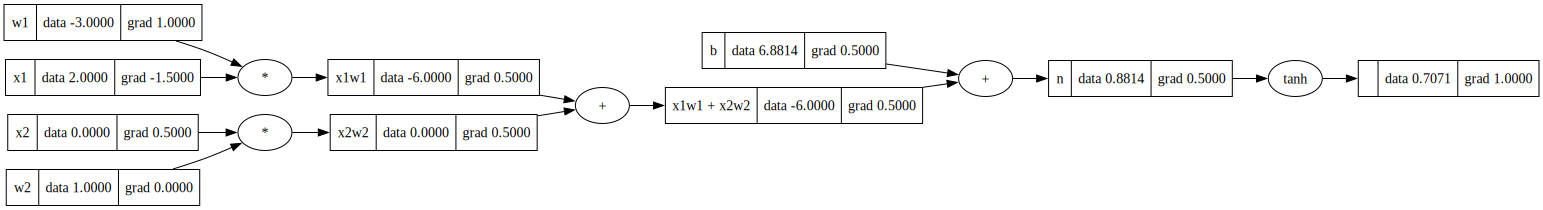

In [80]:
draw_dot(o)

In [62]:
o.grad = 1.0

In [63]:
# o = tanh(n)
# we could analytically take the derivative of the e^x, etc. function,
# or just use what wikipedia gives us: d/dx(tanh(x)) = 1 - tanh^2(x)
# it's defined in terms of itself! so we don't need to do anything special!
# so since o = tanh(n), do/dn = 1 - o**2

n.grad = 1 - o.data**2

n.grad # n.grad ~= 0.5

0.5000000000138193

In [69]:
# a plus is just a distributor, a router -- [x1*w1 + x2*w2] and b both have derivatives of 1 with respect to n.

x1w1x2w2.grad = 1 * n.grad # = 0.5
b.grad = 1 * n.grad # = 0.5

In [71]:
# again, plus sign router to x1w1 and x2w2
x1w1.grad = 1 * x1w1x2w2.grad # = 0.5
x2w2.grad = 1 * x1w1x2w2.grad # = 0.5

In [79]:
w1.grad = x1.data * x1w1.grad # 2.0 * 0.5
x1.grad = w1.data * x1w1.grad # -3.0 * 0.5

w2.grad = x2.data * x2w2.grad # 0 * 0.5
x2.grad = w2.data * x2w2.grad # 1 * 0.5

# implementing backward pass

In [108]:
# a 2-input neural network

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2 and bias b
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373587, label='b')

#multiply the weights and sum
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# add the bias to get n, which is the 'dot product', our input to the activation function
# (though we haven't added the activation function yet)
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

In [109]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children is a tuple
        self.data = data
        
        self._backward = lambda: None 
        # tells python that this is going to be a function by making an empty function
        # but by default, .backward should do nothing, e.g. for leaf nodes where
        # there is nothing to calculate after it. we will define how to calculate the 
        # derivative on an operation-specific basis.
        
        self._prev = set(_children) # uses set for efficiency.
        # when you add two Value objects, the resulting Value object contains a pointer to the 
        # previous value objects. I would rather _children be _parents but... alas, i must
        # follow along with the programming video. I guess it's fine since we're going backwards
        # now.
        
        self._op = _op
        self.label = label
        self.grad = 0.0 # by default we assume that the gradient is zero, that it is not changing

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward(): 
            # for addition, the gradient will be 1 * whatever the preceding node is.
            # our own grad value will be "global" thing we need!
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        # we've defined how to calculate the gradients for the nodes preceding this one;
        # all we need to do is now call .backward for every node to compute the values of
        # the preceding ones! 
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out

        
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math.exp(x) = e^x
        out = Value(t, (self, ), 'tanh') # (self, ) is a 1-object tuple
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad = (1 - out.data**2) * out.grad # karpathy wrote as (1 - t**2) * out.grad
            
        out._backward = _backward
        return out

In [118]:
o.grad = 1.0 # we need to set the out node's gradient to 1 since .grad method is initialized to 0 in the class
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

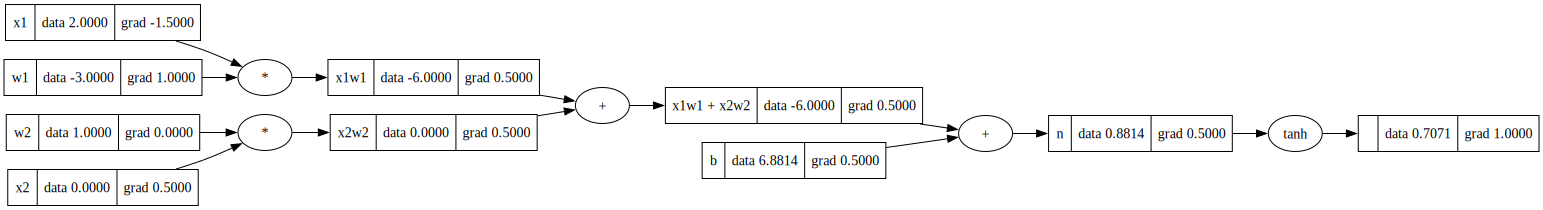

In [119]:
draw_dot(o)

## Automating `._backward()`

I tried using a for loop as follows to automate `._backward()`. I think this doesn't work on more complex and interconnected networks, say, where we skip a layer; we might get incorrect results.

In [116]:
def backward_run(outnode): 
    outnode._backward()
    for child in outnode._prev: 
        backward_run(child)
        
o.grad = 1.0
backward_run(o)

This works for our network above:

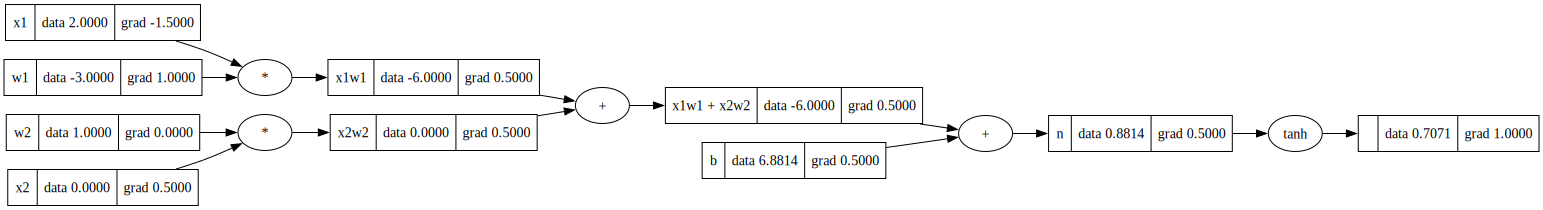

In [117]:
draw_dot(o)

But with a more complex network it will probably get messed up. Karpathy offers a different option, called "**topological sort**." This takes a graph and lays it out "such that all the edges go from left to right." ("directed acyclic graph", <span style="background:yellow">*something to look into later*</span>) 

> Precisely, a topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited. A topological ordering is possible if and only if the graph has no directed cycles, that is, if it is a directed acyclic graph (DAG). 

The algorithm is pretty simple:

In [128]:
o.grad = 1.0

topo = [] # ordered list
visited = set()
def build_topo(v): 
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) #topo.append only runs *after* the for loop has run on all its children!
        
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587),
 Value(data=0.8813735869999997),
 Value(data=0.7071067811767758)]

This is similar-ish to my for loop that I wrote, but with the extra layer on top of it which recurses *backwards then forwards* through the network -- goes back through from the end node, then runs topo.append() from the start nodes through to the end node. This offers us a nice ordered tuple that we can then just `for-in` on.

In [129]:
for node in reversed(topo): 
    node._backward()

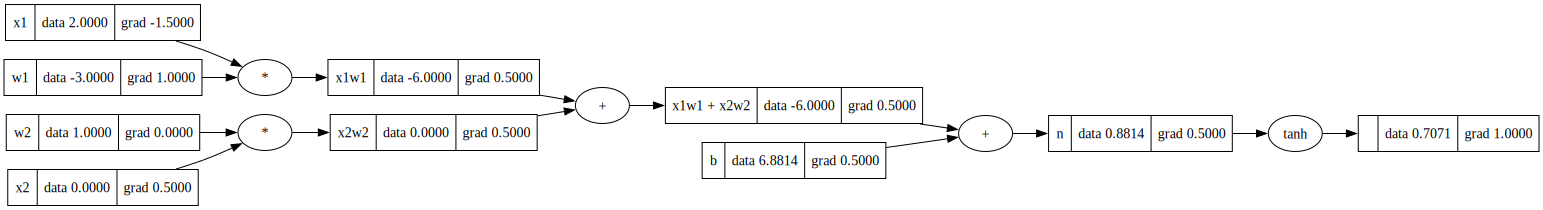

In [130]:
draw_dot(o)

In [ ]:
# putting it all together so that we can stick it into the Value class
def backward(self)

    topo = [] # ordered list
    visited = set()
    def build_topo(v): 
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v) #topo.append only runs *after* the for loop has run on all its children!

    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo): 
        node._backward


## the completed value pass

In [151]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children is a tuple
        self.data = data
        
        self._backward = lambda: None 
        # tells python that this is going to be a function by making an empty function
        # but by default, .backward should do nothing, e.g. for leaf nodes where
        # there is nothing to calculate after it. we will define how to calculate the 
        # derivative on an operation-specific basis.
        
        self._prev = set(_children) # uses set for efficiency.
        # when you add two Value objects, the resulting Value object contains a pointer to the 
        # previous value objects. I would rather _children be _parents but... alas, i must
        # follow along with the programming video. I guess it's fine since we're going backwards
        # now.
        
        self._op = _op
        self.label = label
        self.grad = 0.0 # by default we assume that the gradient is zero, that it is not changing

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward(): 
            # for addition, the gradient will be 1 * whatever the preceding node is.
            # our own grad value will be "global" thing we need!
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        # we've defined how to calculate the gradients for the nodes preceding this one;
        # all we need to do is now call .backward for every node to compute the values of
        # the preceding ones! 
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out

        
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math.exp(x) = e^x
        out = Value(t, (self, ), 'tanh') # (self, ) is a 1-object tuple
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad = (1 - out.data**2) * out.grad # karpathy wrote as (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] # ordered list
        visited = set()
        def build_topo(v): 
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) #topo.append only runs *after* the for loop has run on all its children!

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo): 
            node._backward()


In [152]:
# a 2-input neural network

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2 and bias b
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373587, label='b')

#multiply the weights and sum
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# add the bias to get n, which is the 'dot product', our input to the activation function
# (though we haven't added the activation function yet)
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

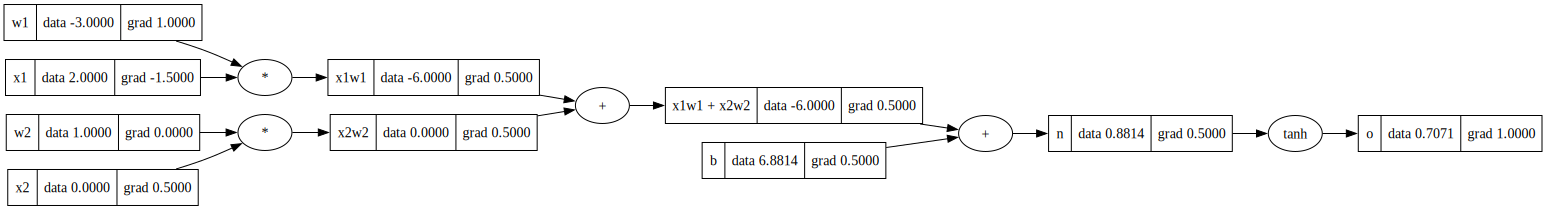

In [153]:
o.backward()

draw_dot(o)

## Squashing bugs in our implementation

So actually there's a bug. Check it out:

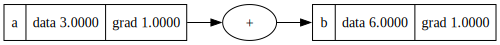

In [154]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b) #two arrows 

The bug is a little tricky. $b = a + a$, which equals $2a$. Hence, $\frac{db}{da} = 2$ and the gradient isn't correct here (right now it displays two nodes overlaid with $\frac{db}{da} = 1$. This is visible also in networks with more nodes:

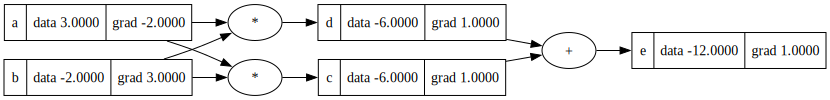

In [160]:
a = Value(3.0, label = 'a')
b = Value(-2.0, label = 'b') 
c = a * b; c.label='c'
d = a * b; d.label='d'
e = c + d; e.label='e'
e.backward()
draw_dot(e)

Here `a` has a gradient of `-2.0`. But when we find the numerical gradient, it's revealed to actually be `-4.0`. 

In [167]:
a = Value(3.0, label = 'a')
b = Value(-2.0, label = 'b') 
c = a * b; c.label='c'
d = a * b; d.label='d'
e = c + d; e.label='e'

f_x = e.data

h = 0.00001

a = Value(3.0 + h, label = 'a')
b = Value(-2.0, label = 'b') 
c = a * b; c.label='c'
d = a * b; d.label='d'
e = c + d; e.label='e'

f_xh = e.data

a_empirical_grad = (f_xh - f_x)/h
print(a_empirical_grad)

-4.000000000026205


This bug results from our `_backward()` functions. 


```python
        # in __add__
        def _backward(): 
            # for addition, the gradient will be 1 * whatever the preceding node is.
            # our own grad value will be "global" thing we need!
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            
        ...
        
        # in __mul__
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

```

Whenever we use a gradient multiple times, we end up with the gradient that is last computed. What we actually need to do is *add* the gradient.

I think that making these `=`s into `+=`s will solve the problem. Let's try it:

In [168]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children is a tuple
        self.data = data
        
        self._backward = lambda: None 
        # tells python that this is going to be a function by making an empty function
        # but by default, .backward should do nothing, e.g. for leaf nodes where
        # there is nothing to calculate after it. we will define how to calculate the 
        # derivative on an operation-specific basis.
        
        self._prev = set(_children) # uses set for efficiency.
        # when you add two Value objects, the resulting Value object contains a pointer to the 
        # previous value objects. I would rather _children be _parents but... alas, i must
        # follow along with the programming video. I guess it's fine since we're going backwards
        # now.
        
        self._op = _op
        self.label = label
        self.grad = 0.0 # by default we assume that the gradient is zero, that it is not changing

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward(): 
            # for addition, the gradient will be 1 * whatever the preceding node is.
            # our own grad value will be "global" thing we need!
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        # we've defined how to calculate the gradients for the nodes preceding this one;
        # all we need to do is now call .backward for every node to compute the values of
        # the preceding ones! 
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

        
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math.exp(x) = e^x
        out = Value(t, (self, ), 'tanh') # (self, ) is a 1-object tuple
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad += (1 - out.data**2) * out.grad # karpathy wrote as (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] # ordered list
        visited = set()
        def build_topo(v): 
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) #topo.append only runs *after* the for loop has run on all its children!

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo): 
            node._backward()


Now let's try it:

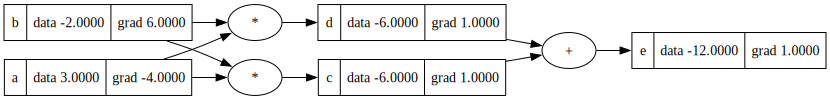

In [169]:
a = Value(3.0, label = 'a')
b = Value(-2.0, label = 'b') 
c = a * b; c.label='c'
d = a * b; d.label='d'
e = c + d; e.label='e'
e.backward()
draw_dot(e)

Looks like the problem is fixed now!

I found this solution myself before I watched how Karpathy did it (he just did the exact same thing lol).  He says it has something to do with the multivariable chain rule -- the derivatives *accumulate* over time -- but I didn't know that going in; this was just the intuitive solution that I got when I thought about it a little bit.

# Implementing more functionality

A couple things we might want to do: 

- add functionality so that we can add simple integers (e.g. `a = Value(2.0); a += 1`) 
- add exponentiation and division

### Adding integers

In [171]:
def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    # sets other to itself if it is an instance of the Value class, otherwise
    # it sets other to Value(other), making it an instance of the Value class.

    out = Value(self.data + other.data, (self, other), '+')

    def _backward(): 
        # for addition, the gradient will be 1 * whatever the preceding node is.
        # our own grad value will be "global" thing we need!
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad

    out._backward = _backward
    # we've defined how to calculate the gradients for the nodes preceding this one;
    # all we need to do is now call .backward for every node to compute the values of
    # the preceding ones! 

    return out

Then we do the same implementation for `__mul__` as well. 

This works for `a + 1` but doesn't work for `1 + a` because python doesn't *actually* treat these things as commutative. For `a + 1` it's callling `a.__add__(1)` but for `1 + a` it's calling `1.__add__(a)`. For the `__add__` function defined within the `Value` class, `__add__` can work with objects of type `int`. But the `__add__` defined for the class `int` doesn't know how to deal with `Value` objects. 

What we can do, though, is define `__radd__` (or `__rmul__` or `__rsub__`) in the `Value` class: `__rmul__`, short for something like "right multiplication," tells Python how to deal with cases where `Value` objects are to the right of the operator instead of the left. (I believe that `__rmul__` is only used when the `__mul__` throws a `TypeError` or some other kind of error -- first it will try multiplication on the object on the left, then if that fails it'll try the right side.)

In [179]:
def __radd__(self, other): # other + self
    return self + other
    # rather than reimplementing the whole thing, 
    # we can just call our existing function lol
        

def __rmul__(self, other): 
    return self * other
        

### `exp` ($e^x$) function

Note that this isn't, say, a generic exponential function; this is an $e^x$ function, i.e. `exp(a)` = $e^{a}$

In [ ]:
def exp(self):
    x = self.data
    t = e**x
    out = Value(t, (self, ), 'exp') # (self, ) is a 1-object tuple

    def _backward(): 
        self.grad += t * out.grad # e^x is its own derivative

    out._backward = _backward
    return out
    

### subtraction and negative signs

In [ ]:
def __neg__(self): 
    return self * -1

def __sub__(self, other): # self - other
    return self + (other * -1)

def __rsub__
    return other + (self * -1)

### division -- or actually, exponentiation ($x^k$)

karpaththy says "let's implement something more powerful than division!" because $\frac{a}{b}$ can be rewritten as $$\frac{a}{b} = a \cdot \frac{1}{b} = a \cdot b^{-1}$$ and thus division is just exponentiation.

Karpathy only wrote a function that supported `int` and `float` inputs to the power, not `Value`s. So I wrote my own that supports `Value`s:

In [ ]:
    def __pow__(self, other): # self ** other
        other = other if isinstance(other, Value) else Value(other, label=str(other))
        t = self.data ** other.data
        out = Value(t, (self, other), f'{self.label}**{other.label}')

        def _backward(): 
            self.grad = other.data * (self.data ** (other.data - 1.0)) * out.grad # don't forget to chain it!

        out.backward = _backward
        return out
    
    def __rpow__(self, other): # other ** self
        other = other if isinstance(other, Value) else Value(other, label=str(other))
        return other ** self

There's a distinction between `__div__` and `__truediv__` and I don't care about it here. :(

In [ ]:
    def __div__(self, other): # self / other
        return self * other**-1
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rdiv__(self, other): # other / self
        return other * self**-1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1

The important part here is that the gradients are *still correct*, even if the graph looks messier when we run it -- by rewriting expressions in terms of things we've already implemented, we save ourselves work and continue getting correct results.

# final implementation

In [267]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children is a tuple
        self.data = data
        
        self._backward = lambda: None 
        # tells python that this is going to be a function by making an empty function
        # but by default, .backward should do nothing, e.g. for leaf nodes where
        # there is nothing to calculate after it. we will define how to calculate the 
        # derivative on an operation-specific basis.
        
        self._prev = set(_children) # uses set for efficiency.
        # when you add two Value objects, the resulting Value object contains a pointer to the 
        # previous value objects. I would rather _children be _parents but... alas, i must
        # follow along with the programming video. I guess it's fine since we're going backwards
        # now.
        
        self._op = _op
        self.label = label
        self.grad = 0.0 # by default we assume that the gradient is zero, that it is not changing

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # sets other to itself if it is an instance of the Value class, otherwise
        # it sets other to Value(other), making it an instance of the Value class.

        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            # for addition, the gradient will be 1 * whatever the preceding node is.
            # our own grad value will be "global" thing we need!
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        # we've defined how to calculate the gradients for the nodes preceding this one;
        # all we need to do is now call .backward for every node to compute the values of
        # the preceding ones! 

        return out
    
    def __radd__(self, other): # other + self
        return self + other
        # rather than reimplementing the whole thing, 
        # we can just call our existing function lol
        
    def __neg__(self): 
        return self * -1

    def __sub__(self, other): # self - other
        return self + (other * -1)

    def __rsub__(self, other): # other - self
        return other + (self * -1)

    def __mul__(self, other):
        
        other = other if isinstance(other, Value) else Value(other)
        # sets other to itself if it is an instance of the Value class, otherwise
        # it sets other to Value(other), making it an instance of the Value class.

        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other): 
        return self * other
    
    
    def __pow__(self, other): # self ** other
        other = other if isinstance(other, Value) else Value(other, label=str(other))
        t = self.data ** other.data
        out = Value(t, (self, other), f'{self.label}**{other.label}')

        def _backward(): 
            self.grad = other.data * (self.data ** (other.data - 1.0)) * out.grad # don't forget to chain it!

        out.backward = _backward
        return out
    
    def __rpow__(self, other): # other ** self
        other = other if isinstance(other, Value) else Value(other, label=str(other))
        return other ** self
    
    def __div__(self, other): # self / other
        return self * other**-1
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rdiv__(self, other): # other / self
        return other * self**-1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1


    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self, ), 'exp') # (self, ) is a 1-object tuple

        def _backward(): 
            self.grad += t * out.grad # e^x is its own derivative

        out._backward = _backward
        return out

        
    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # math.exp(x) = e^x
        out = Value(t, (self, ), 'tanh') # (self, ) is a 1-object tuple
        
        def _backward(): 
            # same method as above _backward() for __add__()
            self.grad += (1 - out.data**2) * out.grad # karpathy wrote as (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] # ordered list
        visited = set()
        def build_topo(v): 
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) #topo.append only runs *after* the for loop has run on all its children!

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo): 
            node._backward()


In [268]:
a = Value(2.0)
b = a + 1
print(b)
b = 1 + a
print(b)

Value(data=3.0)
Value(data=3.0)


In [269]:
a = Value(2.0)
b = a * 1
print(b)
b = 1 * a
print(b)

Value(data=2.0)
Value(data=2.0)


In [270]:
a = Value(2.0)
b = a.exp()
print(b)

print(math.e**2) # math.e is the number e

Value(data=7.38905609893065)
7.3890560989306495


In [271]:
a = Value(2.0)
print(a**6, 2**6) # uses ints and floats!
print(6.5**a, 6.5**2)

b = Value(3.0)
print(a**b, 2.0**3)

Value(data=64.0) 64
Value(data=42.25) 42.25
Value(data=8.0) 8.0


In [272]:
print(a/3)
print(3/a)
print(a/b)
print(2/3)

Value(data=0.6666666666666666)
Value(data=1.5)
Value(data=0.6666666666666666)
0.6666666666666666


Let's check our gradient implementations as well:

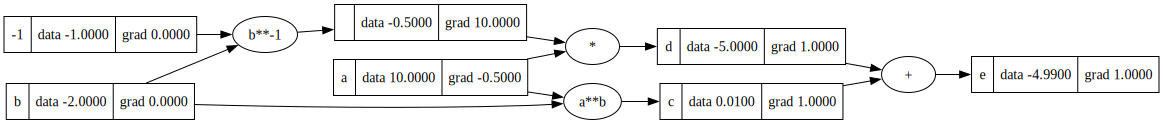

In [273]:
a = Value(10.0, label = 'a')
b = Value(-2.0, label = 'b') 
c = a ** b; c.label='c'
d = a / b; d.label='d'
e = c + d; e.label='e'
e.backward()
draw_dot(e)

In [262]:
a = Value(10.0, label = 'a')
b = Value(-2.0, label = 'b') 
c = a ** b; c.label='c'
d = a / b; d.label='d'
e = c + d; e.label='e'
f_x = e.data

h = 0.000000001

a = Value(10.0+h, label = 'a')
b = Value(-2.0, label = 'b') 
c = a ** b; c.label='c'
d = a / b; d.label='d'
e = c + d; e.label='e'

f_xh = e.data

a_empirical_grad = (f_xh - f_x)/h
print(a_empirical_grad)

-0.5020002191713502
